In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay
)
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # type: ignore
import lightgbm as lgb # type: ignore

import warnings
warnings.filterwarnings("ignore")


In [24]:
df = pd.read_csv("../data/diabetes_dataset.csv")
print("Shape:", df.shape)
print(df.head())


Shape: (100000, 31)
   age  gender ethnicity education_level  income_level employment_status  \
0   58    Male     Asian      Highschool  Lower-Middle          Employed   
1   48  Female     White      Highschool        Middle          Employed   
2   60    Male  Hispanic      Highschool        Middle        Unemployed   
3   74  Female     Black      Highschool           Low           Retired   
4   46    Male     White        Graduate        Middle           Retired   

  smoking_status  alcohol_consumption_per_week  \
0          Never                             0   
1         Former                             1   
2          Never                             1   
3          Never                             0   
4          Never                             1   

   physical_activity_minutes_per_week  diet_score  ...  hdl_cholesterol  \
0                                 215         5.7  ...               41   
1                                 143         6.7  ...               55 

In [25]:
TARGET_COL = "diagnosed_diabetes"

if TARGET_COL not in df.columns:
    raise ValueError(f"'{TARGET_COL}' not found in columns: {list(df.columns)[:10]} ...")

# coerce to 0/1 robustly in case dtype is float/bool
y = df[TARGET_COL].astype(int).clip(0, 1)
print("Class counts (0=no, 1=yes):\n", y.value_counts())

# drop target and any leakage cols if present
leakage_like = {"diabetes_risk_score", "diabetes_stage", TARGET_COL}
X = df.drop(columns=[c for c in leakage_like if c in df.columns])

Class counts (0=no, 1=yes):
 diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

def get_transformed_feature_names(fitted_preprocessor):
    names = []
    if num_cols:
        names.extend(num_cols)
    if cat_cols:
        ohe = fitted_preprocessor.named_transformers_["cat"].named_steps["onehot"]
        names.extend(list(ohe.get_feature_names_out(cat_cols)))
    return np.array(names, dtype=object)


In [28]:
models = []

# logistic Regression (balanced)
models.append((
    "LogisticRegression",
    Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", LogisticRegression(
            max_iter=2000, class_weight="balanced", solver="lbfgs"
        ))
    ])
))

# random forest model
models.append((
    "RandomForest",
    Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=400, max_depth=None, n_jobs=-1,
            class_weight="balanced_subsample", random_state=42
        ))
    ])
))

# XGBoost — use scale_pos_weight for imbalance
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw = max(1.0, neg / max(pos, 1))
models.append((
    "XGBoost",
    Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            eval_metric="logloss",
            tree_method="hist",
            scale_pos_weight=spw
        ))
    ])
))

# LightGBM
models.append((
    "LightGBM",
    Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", lgb.LGBMClassifier(
            n_estimators=600,
            learning_rate=0.05,
            num_leaves=63,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            class_weight="balanced"
        ))
    ])
))


===== LogisticRegression =====
Validation Accuracy: 0.8877  |  Precision: 0.9312  |  Recall: 0.8776  |  F1: 0.9036  |  ROC-AUC: 0.9339

Classification report:
               precision    recall  f1-score   support

           0     0.8310    0.9028    0.8654      8000
           1     0.9312    0.8776    0.9036     12000

    accuracy                         0.8877     20000
   macro avg     0.8811    0.8902    0.8845     20000
weighted avg     0.8911    0.8877    0.8883     20000



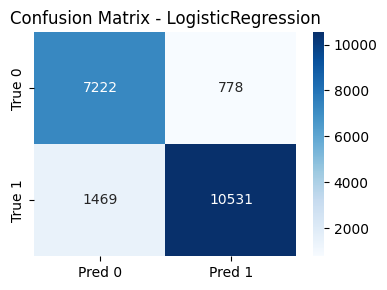

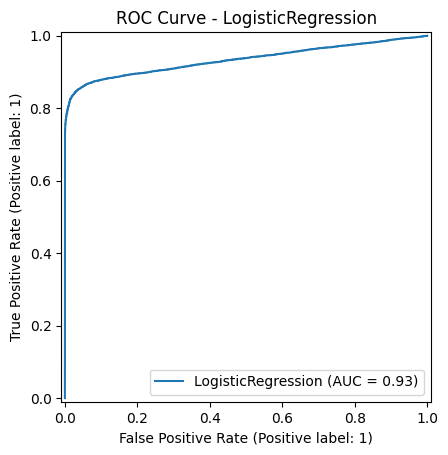


===== RandomForest =====
Validation Accuracy: 0.9196  |  Precision: 0.9993  |  Recall: 0.8666  |  F1: 0.9282  |  ROC-AUC: 0.9414

Classification report:
               precision    recall  f1-score   support

           0     0.8331    0.9991    0.9086      8000
           1     0.9993    0.8666    0.9282     12000

    accuracy                         0.9196     20000
   macro avg     0.9162    0.9329    0.9184     20000
weighted avg     0.9328    0.9196    0.9204     20000



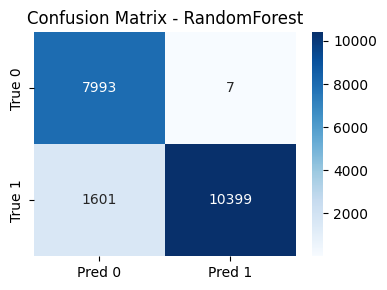

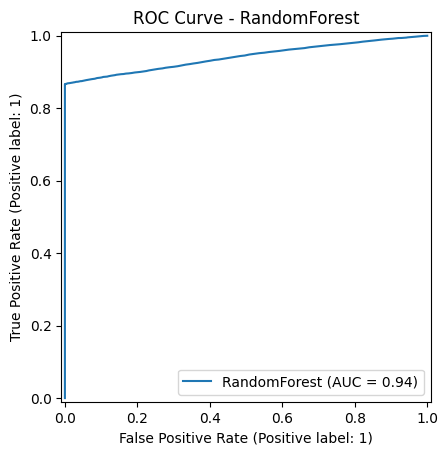


===== XGBoost =====
Validation Accuracy: 0.9196  |  Precision: 0.9993  |  Recall: 0.8666  |  F1: 0.9282  |  ROC-AUC: 0.9417

Classification report:
               precision    recall  f1-score   support

           0     0.8331    0.9991    0.9086      8000
           1     0.9993    0.8666    0.9282     12000

    accuracy                         0.9196     20000
   macro avg     0.9162    0.9329    0.9184     20000
weighted avg     0.9328    0.9196    0.9204     20000



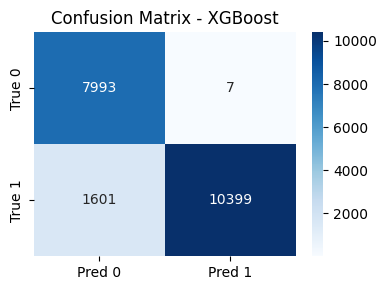

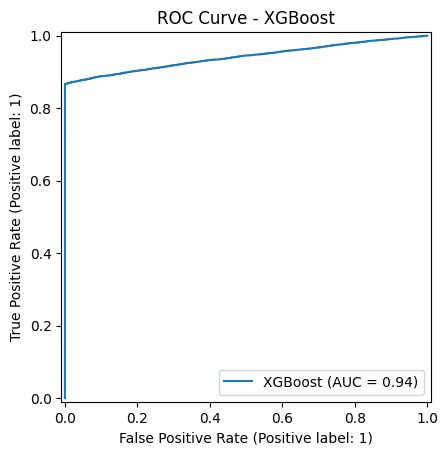


===== LightGBM =====
[LightGBM] [Info] Number of positive: 47998, number of negative: 32002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Validation Accuracy: 0.9196  |  Precision: 0.9992  |  Recall: 0.8668  |  F1: 0.9283  |  ROC-AUC: 0.9399

Classification report:
               precision    recall  f1-score   support

           0     0.8333    0.9990    0.9086      8000
           1     0.9992    0.8668    0.9283     12000

    accuracy                         0.9196     20000
   macro avg     0.9163    0.9329    0.9185     20000
weighted avg     0.

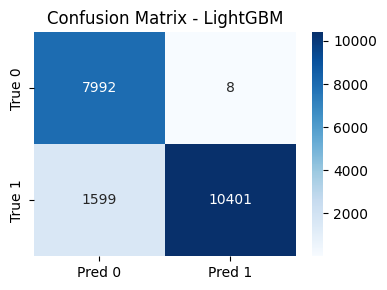

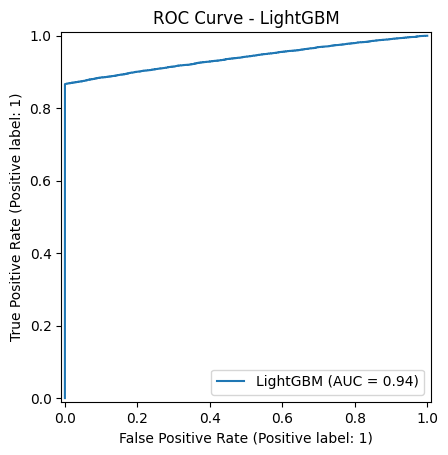


===== Model Comparison =====
                model  validation accuracy  precision    recall        f1  \
2             XGBoost              0.91960   0.999327  0.866583  0.928234   
1        RandomForest              0.91960   0.999327  0.866583  0.928234   
3            LightGBM              0.91965   0.999231  0.866750  0.928288   
0  LogisticRegression              0.88765   0.931205  0.877583  0.903599   

    roc_auc  
2  0.941686  
1  0.941373  
3  0.939867  
0  0.933937  


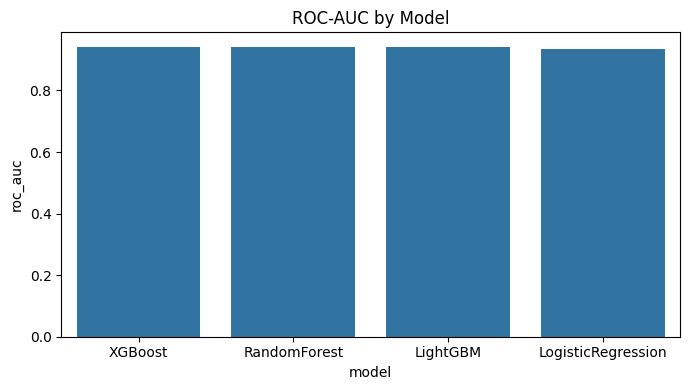

In [36]:
def print_confusion(cm, title):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Pred 0","Pred 1"],
                yticklabels=["True 0","True 1"])
    plt.title(title)
    plt.tight_layout()
    plt.show()

results = []

for name, pipe in models:
    print(f"\n===== {name} =====")
    pipe.fit(X_train, y_train)

    # preds
    y_pred = pipe.predict(X_test)
    proba = None
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba = pipe.predict_proba(X_test)[:, 1]
    elif hasattr(pipe.named_steps["clf"], "decision_function"):
        # map decision_function to [0,1] with a sigmoid-ish transform
        dec = pipe.decision_function(X_test)
        proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

    # metrics
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    roc = roc_auc_score(y_test, proba) if proba is not None else np.nan

    print(f"Validation Accuracy: {acc:.4f}  |  Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  F1: {f1:.4f}  |  ROC-AUC: {roc:.4f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    print_confusion(cm, f"Confusion Matrix - {name}")

    # roc curve
    if proba is not None:
        RocCurveDisplay.from_predictions(y_test, proba, name=name)
        plt.title(f"ROC Curve - {name}")
        plt.show()

    results.append({
        "model": name, "validation accuracy": acc, "precision": prec,
        "recall": rec, "f1": f1, "roc_auc": roc
    })

# summary table
summary = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
print("\n===== Model Comparison =====")
print(summary)

plt.figure(figsize=(7,4))
sns.barplot(x="model", y="roc_auc", data=summary)
plt.title("ROC-AUC by Model")
plt.tight_layout()
plt.show()

In [37]:
best_name = summary.iloc[0]["model"]
best_pipe = dict(models)[best_name]
print(f"\nComputing permutation importance for: {best_name}")

best_pipe.fit(X_train, y_train)

# get transformed feature names (sklearn >= 1.0)
try:
    feat_names = best_pipe.named_steps["prep"].get_feature_names_out()
except Exception:
    # fallback (older sklearn): build names manually
    num_feats = np.array(num_cols, dtype=object)
    if cat_cols:
        ohe = best_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
        cat_feats = ohe.get_feature_names_out(cat_cols)
        feat_names = np.concatenate([num_feats, cat_feats])
    else:
        feat_names = num_cols

r = permutation_importance(
    best_pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False).head(20)

print("\nTop 20 permutation importances:")
print(imp_df)

plt.figure(figsize=(8,6))
sns.barplot(y="feature", x="importance_mean", data=imp_df)
plt.title(f"Top 20 Permutation Importances - {best_name}")
plt.tight_layout()
plt.show()


Computing permutation importance for: XGBoost


ValueError: All arrays must be of the same length